# Test IBL model implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from scipy.special import logit

from bfdm.ibltask import sample_biased_trials
from bfdm.iblmodel import get_optimal_params, sample_behavior, fit_ibl

In [2]:
rng = default_rng(999)

## Create synthetic data

In [3]:
n_trials = 1000
p_stay = 0.98
p_side = 0.8
noise = 1.0

b, s, x = sample_biased_trials(n_trials, p_stay, p_side, noise)

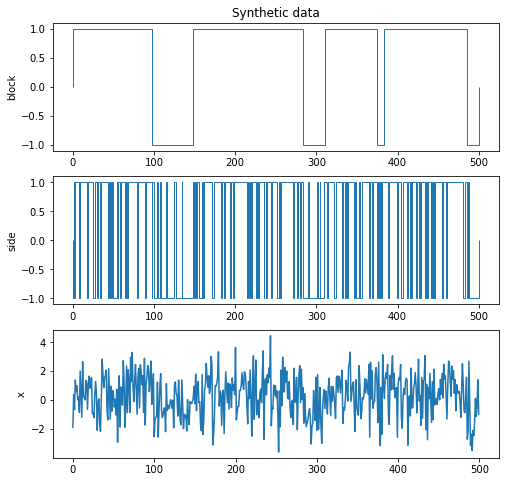

In [4]:
idx = np.s_[0:500]

(fig, ax) = plt.subplots(3, 1, figsize=(8, 8))

ax[0].stairs(b[idx])
ax[0].set_ylabel('block')

ax[1].stairs(s[idx])
ax[1].set_ylabel('side')

ax[2].plot(x[idx])
ax[2].set_ylabel('x')

ax[0].set_title('Synthetic data');

## Run agent with optimal parameters on data

In [5]:
# Optimal values for bias and weight
params = get_optimal_params(p_stay, p_side, noise)

# Choice samples and filter result
y, flt = sample_behavior(s, x, params, rng)

# Compute error from predictions
err = (s - y) ** 2
win_size = 50
err_smooth = np.convolve(err, np.ones(win_size), 'same') / win_size

# Compute average accuracy
acc = np.count_nonzero((y * s) == 1) / n_trials

### Filter results

avg. accuracy: 0.829


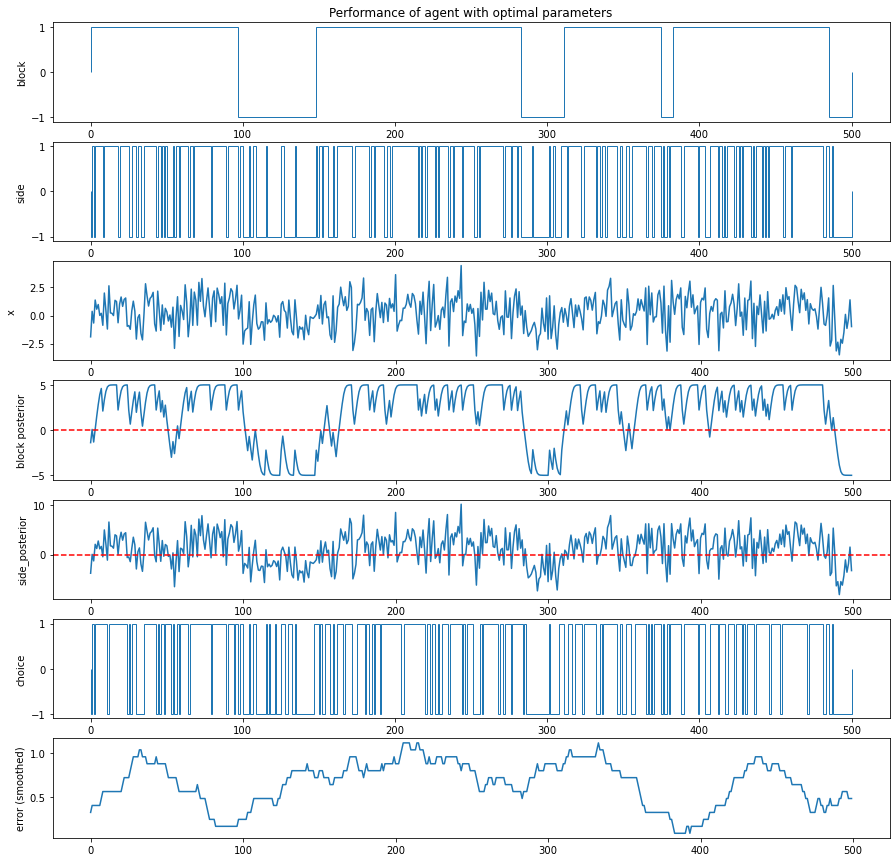

In [6]:
idx = np.s_[0:500]

(fig, ax) = plt.subplots(7, 1, figsize=(15, 15))

ax[0].stairs(b[idx])
ax[0].set_ylabel('block')

ax[1].stairs(s[idx])
ax[1].set_ylabel('side')

ax[2].plot(x[idx])
ax[2].set_ylabel('x')

ax[3].plot(flt.b_pos[idx])
ax[3].axhline(y=0, color='r', linestyle='--')
ax[3].set_ylabel('block posterior')

ax[4].plot(flt.s_pos[idx])
ax[4].axhline(y=0, color='r', linestyle='--')
ax[4].set_ylabel('side_posterior')

ax[5].stairs(y[idx])
ax[5].set_ylabel('choice')

ax[6].plot(err_smooth[idx])
ax[6].set_ylabel('error (smoothed)')

ax[0].set_title('Performance of agent with optimal parameters')

print(f'avg. accuracy: {acc}')

## Recover model parameters from prediction data

In [7]:
# Fit model to predictions from optimal model
params_est = fit_ibl([s], [x], [y])

In [8]:
# Print parameters of fit model
print(f'alpha: {params_est.alpha} (opt: {params.alpha})')
print(f'p_stay: {params_est.p_stay()} (opt: {params.p_stay()})')
print(f'beta: {params_est.beta} (opt: {params.beta})')
print(f'p_side: {params_est.p_side()} (opt: {params.p_side()})')
print(f'w_0: {params_est.bias} (opt: {params.bias})')
print(f'w_1: {params_est.coef} (opt: {params.coef})')

alpha: 4.48281569429001 (opt: 3.8918202981106256)
p_stay: 0.9888247509854061 (opt: 0.98)
beta: 1.4727992326952708 (opt: 1.3862943611198908)
p_side: 0.8134824828113703 (opt: 0.8)
w_0: 0.08172591009881515 (opt: 0)
w_1: 2.0282205619656906 (opt: 2.0)


## Test optimal agent performance for varying noise values

In [12]:
def test_accuracy(n_trials=8000, p_stay=0.98, p_side=0.8, noise=1.0):
    
    # Sample synthetic data
    _, s, x = sample_biased_trials(n_trials, p_stay, p_side, noise)
    
    # Sample choices with optimal parameters
    params = get_optimal_params(p_stay, p_side, noise)
    y, _ = sample_behavior(s, x, params, rng)

    # Return accuracy
    return np.count_nonzero((y * s) == 1) / n_trials

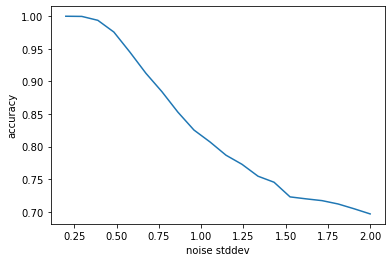

In [13]:
noise_vals = np.linspace(0.2, 2.0, 20)
acc_vals = [test_accuracy(noise=n) for n in noise_vals]

plt.plot(noise_vals, acc_vals)
plt.xlabel('noise stddev')
plt.ylabel('accuracy');

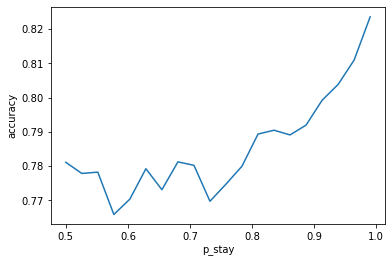

In [14]:
p_stay_vals = np.linspace(0.5, 0.99, 20)
acc_vals = [test_accuracy(p_stay=p) for p in p_stay_vals]

plt.plot(p_stay_vals, acc_vals)
plt.xlabel('p_stay')
plt.ylabel('accuracy');

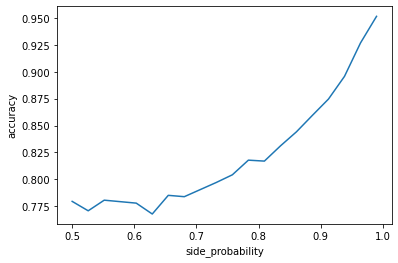

In [17]:
p_side_vals = np.linspace(0.5, 0.99, 20)
acc_vals = [test_accuracy(p_side=p) for p in p_side_vals]

plt.plot(p_side_vals, acc_vals)
plt.xlabel('side_probability')
plt.ylabel('accuracy');